## 导入相应的包

In [1]:
import torch
import torchvision
cuda_enable = torch.cuda.is_available()
print 'cuda is available' if cuda_enable else 'cuda is not available'

cuda is available


## LeNet

In [2]:
import torch.nn as nn
import torch.nn.functional as F
class lenet(nn.Module):
    def __init__(self):
        super(lenet, self).__init__()
        # conv1, 20 channels, 5x5 kernel, stride = 1
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        # conv2, 50 channels, 5x5 kernel, stride = 1
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        # fc1, 500 output
        self.fc1 = nn.Linear(4*4*50, 100)
        # fc2, 10 output
        self.fc2 = nn.Linear(100, 10)
    def forward(self, x):
        # 1st conv-pooling-relu unit
        x = F.relu(F.max_pool2d(self.conv1(x), 2, 2))
        # 2nd conv-pooling-relu unit
        x = F.relu(F.max_pool2d(self.conv2(x), 2, 2))
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

model = lenet()
if cuda_enable:
    model.cuda()
# show model
model

lenet (
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (800 -> 100)
  (fc2): Linear (100 -> 10)
)

## Load dataset

In [3]:
from torchvision import datasets, transforms
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda_enable else {}
data_dir = '../data'
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),  # to Tensor
                               # transforms.Normalize((0.1307,), (0.3081,))  # normalization
                               transforms.Normalize((0.5,), (1,))  # normalization
                               ])
if_download = False  # we have download the mnist
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir, train = True, 
                   download = if_download,
                   transform = transform),
                   batch_size = batch_size, 
                   shuffle = True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir, train=False, 
                   transform = transform),
                   batch_size = batch_size, 
                   shuffle = True, **kwargs)
print 'total batch number in train set: {}'.format(len(train_loader))
print 'total batch number in test set: {}'.format(len(test_loader))

total batch number in train set: 469
total batch number in test set: 79


## Optimization 方法

To construct an Optimizer you have to give it an iterable containing the parameters (all should be Variable s) to optimize. Then, you can specify optimizer-specific options such as the learning rate, weight decay, etc.
Example:
```
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
optimizer = optim.Adam([var1, var2], lr = 0.0001)
```

In [4]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.0005)

Optimizer s also support specifying per-parameter options. To do this, instead of passing an iterable of Variable s, pass in an iterable of dict s. Each of them will define a separate parameter group, and should contain a params key, containing a list of parameters belonging to it. Other keys should match the keyword arguments accepted by the optimizers, and will be used as optimization options for this group.
Example:
```
optim.SGD([
                {'params': model.base.parameters()},
                {'params': model.classifier.parameters(), 'lr': 1e-3}
            ], lr=1e-2, momentum=0.9)
```
This means that model.base‘s parameters will use the default learning rate of 1e-2, model.classifier‘s parameters will use a learning rate of 1e-3, and a momentum of 0.9 will be used for all parameters.

在训练过程中，一旦进行完gradient的bp之后，使用`optimizer.step()`就可以使用给定的优化方法进行参数的更新了。一个典型的训练迭代过程如下所示：

```
for input, target in dataset:
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
```

## 训练网络

In [5]:
# functions to show an image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def imshow(img):
    img = img + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

3, 5, 9, 3, 4, 5, 7, 9, 5, 4, 8, 9, 9, 5, 0, 8, 1, 6, 4, 6, 7, 5, 3, 9, 5, 4, 1, 0, 6, 7, 8, 7, 5, 5, 7, 5, 3, 6, 4, 4, 4, 3, 2, 7, 5, 5, 8, 6, 6, 7, 6, 9, 6, 4, 7, 5, 4, 8, 6, 9, 6, 6, 2, 2, 9, 3, 1, 3, 4, 3, 2, 2, 1, 8, 4, 5, 9, 9, 3, 5, 8, 6, 0, 4, 7, 7, 6, 2, 6, 8, 9, 7, 4, 5, 1, 1, 7, 7, 6, 8, 3, 6, 1, 6, 2, 5, 7, 4, 1, 8, 1, 4, 7, 3, 4, 7, 2, 0, 0, 1, 3, 8, 7, 9, 9, 3, 2, 6


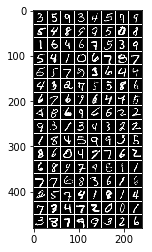

In [6]:
data, label = iter(train_loader).next()
imshow(torchvision.utils.make_grid(data))
print ', '.join(map(lambda x: str(x), label.numpy()))

In [7]:
data = data.cuda()
pred = model(torch.autograd.Variable(data))
print pred.data


 0.0000  0.0798  0.0000  ...   0.0000  0.0006  0.0000
 0.0000  0.0666  0.0000  ...   0.0134  0.0000  0.0000
 0.0000  0.0625  0.0031  ...   0.0244  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  0.0510  0.0000  ...   0.0332  0.0000  0.0000
 0.0000  0.0570  0.0000  ...   0.0268  0.0000  0.0000
 0.0000  0.0687  0.0000  ...   0.0267  0.0000  0.0000
[torch.cuda.FloatTensor of size 128x10 (GPU 0)]



In [8]:
from torch.autograd import Variable

def train(epoch, interval):
    # 首先，设置model phase为TRAIN（对bn和dropout有用）
    model.train()
    # 迭代训练数据集
    for batch_idx, (data, target) in enumerate(train_loader):
        # 第一步，将optimizer的grad buffer清零
        optimizer.zero_grad()
        # 第二步，将data convey到GPU上
        if cuda_enable:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target) 
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % interval == 0:
            print 'epoch {}, batch index: {}, loss = {:.6f}'.format(epoch, batch_idx, loss.data[0])
            

In [9]:
for epoch in xrange(1):
    train(epoch, 100)

epoch 0, batch index: 99, loss = 2.298567
epoch 0, batch index: 199, loss = 2.278311
epoch 0, batch index: 299, loss = 2.246728
epoch 0, batch index: 399, loss = 2.213580


In [9]:
def test(epoch):
    model.eval()
    cnt = 0
    test_loss = 0.
    for data, target in test_loader:
        if cuda_enable:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile = True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data[0]
        pred = torch.max(output.data, 1)[1]
        cnt += (pred == target.data).sum()
    accuracy = cnt * 1.0 / (len(test_loader) * batch_size)
    test_loss /= len(test_loader)
    print 'epoch {}, loss {:.6f}, accuracy: {:.2f}'.format(epoch, test_loss, accuracy)
    
test(0)

epoch 0, loss 2.300526, accuracy: 0.10


In [10]:
for epoch in xrange(30):
    train(epoch, 100)
    test(epoch)

epoch 0, batch index: 99, loss = 2.291751
epoch 0, batch index: 199, loss = 2.283409
epoch 0, batch index: 299, loss = 2.232776
epoch 0, batch index: 399, loss = 2.156245
epoch 0, loss 2.098473, accuracy: 0.44
epoch 1, batch index: 99, loss = 1.909375
epoch 1, batch index: 199, loss = 1.696232
epoch 1, batch index: 299, loss = 1.285969
epoch 1, batch index: 399, loss = 1.090368
epoch 1, loss 1.165558, accuracy: 0.63
epoch 2, batch index: 99, loss = 1.004164
epoch 2, batch index: 199, loss = 0.904048
epoch 2, batch index: 299, loss = 0.841188
epoch 2, batch index: 399, loss = 1.024666
epoch 2, loss 0.746359, accuracy: 0.78
epoch 3, batch index: 99, loss = 0.774889
epoch 3, batch index: 199, loss = 0.715350
epoch 3, batch index: 299, loss = 0.683326
epoch 3, batch index: 399, loss = 0.645122
epoch 3, loss 0.655300, accuracy: 0.82
epoch 4, batch index: 99, loss = 0.737426
epoch 4, batch index: 199, loss = 0.581504
epoch 4, batch index: 299, loss = 0.518285
epoch 4, batch index: 399, loss 